Data summary:
              ssn         year       month     year_tsi   month_tsi  \
count  924.000000   924.000000  924.000000   924.000000  924.000000   
mean    93.807468  1985.583333    6.500000  1985.583333    6.500000   
std     71.508209    22.243618    3.453922    22.243618    3.453922   
min      1.800000  1947.000000    1.000000  1947.000000    1.000000   
25%     28.325000  1966.000000    3.750000  1966.000000    3.750000   
50%     84.050000  1986.000000    6.500000  1986.000000    6.500000   
75%    149.950000  2005.000000    9.250000  2005.000000    9.250000   
max    285.000000  2024.000000   12.000000  2024.000000   12.000000   

               tsi  
count   924.000000  
mean   1363.423637  
std       0.354047  
min    1362.889401  
25%    1363.075220  
50%    1363.427315  
75%    1363.741120  
max    1364.138153  
Correlation between SSN and TSI: 0.9065


2025-03-20 16:25:43.560897: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-20 16:25:43.560926: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-20 16:25:43.560932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-03-20 16:25:43.560947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-20 16:25:43.560958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

Epoch 1/100


2025-03-20 16:25:44.077157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0630
Epoch 1: val_loss improved from inf to 0.01684, saving model to model_checkpoints/model_0.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0620 - val_loss: 0.0168
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0158
Epoch 2: val_loss improved from 0.01684 to 0.00791, saving model to model_checkpoints/model_0.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0157 - val_loss: 0.0079
Epoch 3/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0116
Epoch 3: val_loss improved from 0.00791 to 0.00417, saving model to model_checkpoints/model_0.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0114 - val_loss: 0.0042
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082
Epoch 4: val_loss improved from 0.00417 to 0.00362, saving model to model_checkpoints/model_0.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 

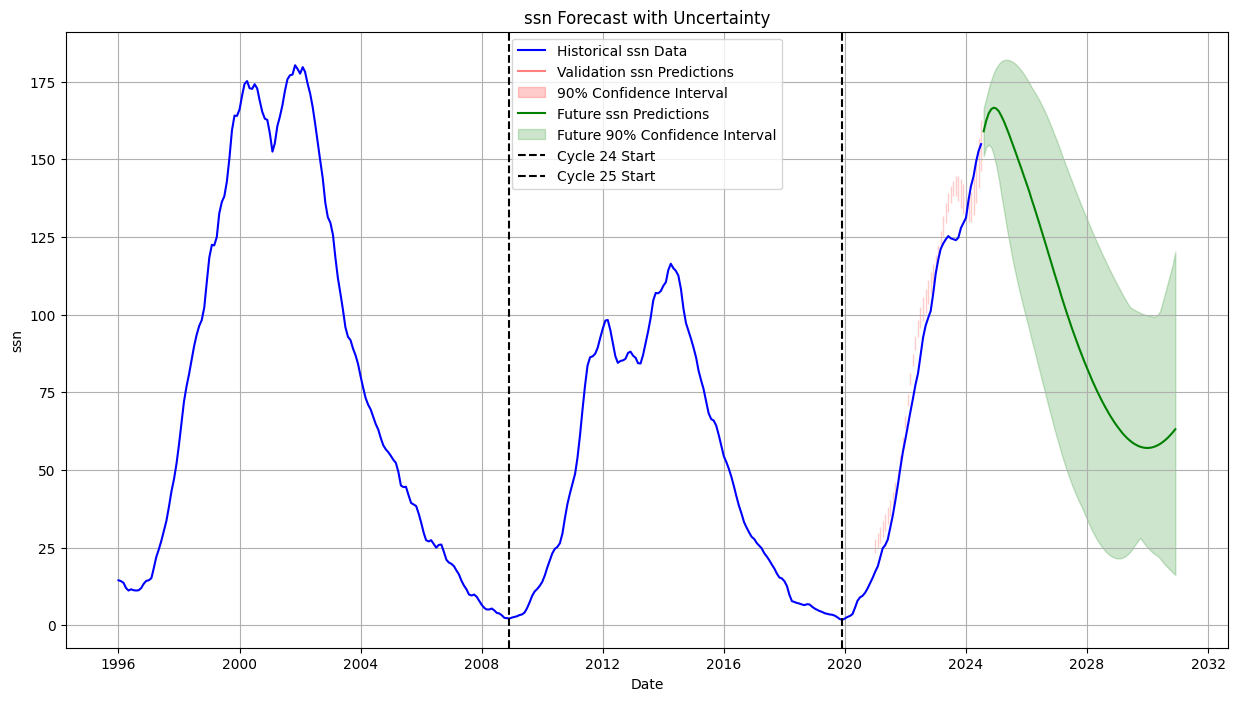

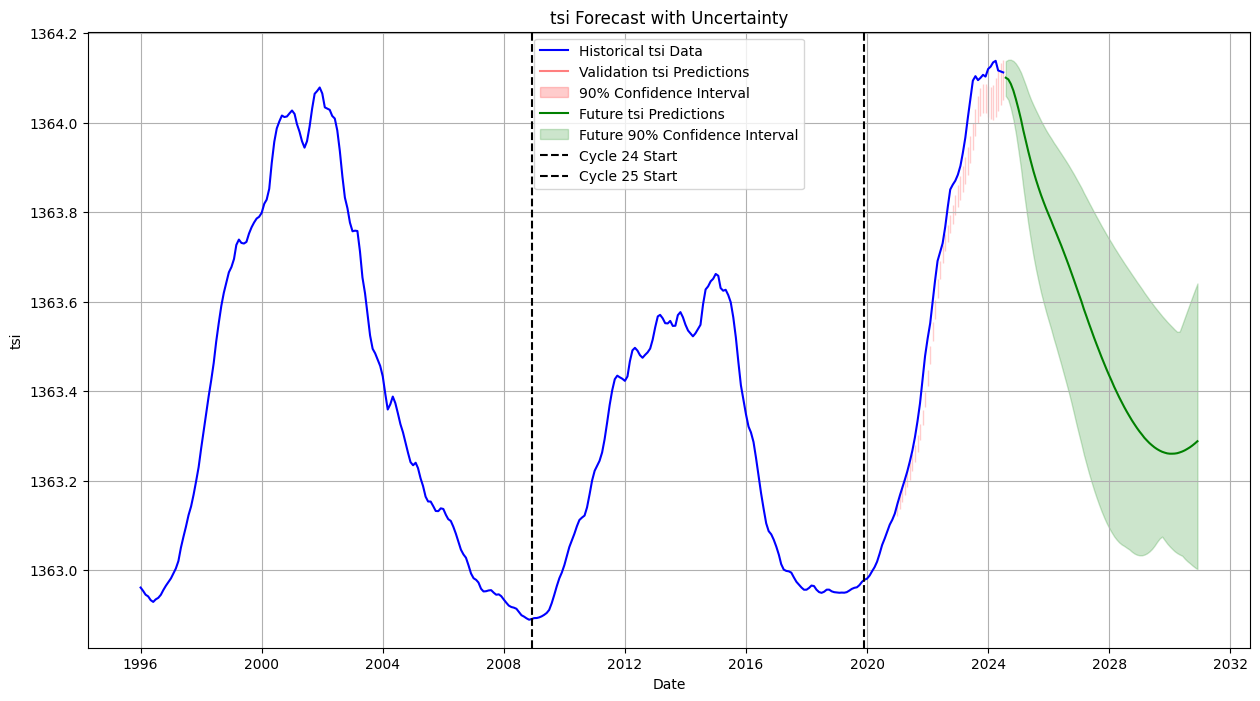

Forecasting process completed successfully


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pickle

np.random.seed(42)
tf.random.set_seed(42)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.set_index('date')
    return df

def create_forecast_sequences(data, seq_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon])
    return np.array(X), np.array(y)

def calculate_metrics(y_true, y_pred, y_lower, y_upper):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_lower = y_lower.flatten()
    y_upper = y_upper.flatten()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    within_interval = np.logical_and(y_true >= y_lower, y_true <= y_upper)
    picp = np.mean(within_interval)
    mpiw = np.mean(y_upper - y_lower)
    
    return rmse, picp, mpiw

def create_train_model(X_train, y_train, forecast_horizon, n_features, model_dir, bootstrap_id):
    os.makedirs(model_dir, exist_ok=True)
    
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], n_features)),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon * 2)  # Output both SSN and TSI predictions
    ])

    model.compile(optimizer='adam', loss='mse')

    checkpoint_path = os.path.join(model_dir, f"model_{bootstrap_id}.keras")
    
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        verbose=1
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    return model, history

def generate_bootstrap_forecasts(X_train, y_train, X_val, forecast_horizon, num_bootstraps=10, save_results=True):
    model_dir = "model_checkpoints"
    os.makedirs(model_dir, exist_ok=True)
    
    results_dir = "forecast_results"
    os.makedirs(results_dir, exist_ok=True)
    
    forecasts = []
    models = []

    for i in range(num_bootstraps):
        indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_bootstrap = X_train[indices]
        y_bootstrap = y_train[indices]

        model, _ = create_train_model(X_bootstrap, y_bootstrap, forecast_horizon, X_train.shape[2], model_dir, i)
        models.append(model)

        forecast = model.predict(X_val, verbose=1)
        forecasts.append(forecast)

    forecasts = np.array(forecasts)

    mean_forecast = np.mean(forecasts, axis=0)
    lower_bound = np.quantile(forecasts, 0.05, axis=0)
    upper_bound = np.quantile(forecasts, 0.95, axis=0)

    if save_results:
        results = {
            'mean_forecast': mean_forecast,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'forecasts': forecasts
        }
        
        results_path = os.path.join(results_dir, 'forecast_results.pkl')
        with open(results_path, 'wb') as f:
            pickle.dump(results, f)

    return mean_forecast, lower_bound, upper_bound, models, forecasts

def load_forecast_results(results_dir="forecast_results"):
    results_path = os.path.join(results_dir, 'forecast_results.pkl')
    
    if not os.path.exists(results_path):
        raise FileNotFoundError(f"Results file not found at {results_path}")
    
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    return results['mean_forecast'], results['lower_bound'], results['upper_bound'], results['forecasts']

def load_trained_models(num_bootstraps, model_dir="model_checkpoints"):
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory {model_dir} not found")
    
    models = []
    for i in range(num_bootstraps):
        model_path = os.path.join(model_dir, f"model_{i}.keras")
        if os.path.exists(model_path):
            model = load_model(model_path)
            models.append(model)
    
    return models

def predict_future(model, last_sequence, future_steps, forecast_horizon, ssn_scaler, tsi_scaler, model_id):
    future_predictions_ssn = []
    future_predictions_tsi = []
    curr_sequence = last_sequence.copy()

    steps_completed = 0
    while steps_completed < future_steps:
        curr_sequence_reshaped = curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1])
        next_preds = model.predict(curr_sequence_reshaped, verbose=0)[0]
        
        # Split the predictions into SSN and TSI
        ssn_preds = next_preds[:forecast_horizon]
        tsi_preds = next_preds[forecast_horizon:]
        
        steps_to_add = min(forecast_horizon, future_steps - steps_completed)
        future_predictions_ssn.extend(ssn_preds[:steps_to_add])
        future_predictions_tsi.extend(tsi_preds[:steps_to_add])
        
        curr_sequence = np.roll(curr_sequence, -steps_to_add, axis=0)
        
        for i in range(steps_to_add):
            curr_sequence[-steps_to_add+i][0] = ssn_preds[i]  # Update SSN
            curr_sequence[-steps_to_add+i][1] = tsi_preds[i]  # Update TSI
        
        steps_completed += steps_to_add

    future_predictions_ssn = np.array(future_predictions_ssn).reshape(-1, 1)
    future_predictions_tsi = np.array(future_predictions_tsi).reshape(-1, 1)
    
    future_predictions_ssn = ssn_scaler.inverse_transform(future_predictions_ssn)
    future_predictions_tsi = tsi_scaler.inverse_transform(future_predictions_tsi)

    return future_predictions_ssn, future_predictions_tsi

def generate_future_dates(last_date, num_months):
    future_dates = pd.date_range(start=last_date, periods=num_months+1, freq='MS')[1:]
    return future_dates

def calculate_evaluation_metrics(actual_values, mean_forecast_inv, lower_bound_inv, upper_bound_inv):
    rmse_values = []
    picp_values = []
    mpiw_values = []

    for i in range(len(actual_values)):
        rmse, picp, mpiw = calculate_metrics(
            actual_values[i],
            mean_forecast_inv[i],
            lower_bound_inv[i],
            upper_bound_inv[i]
        )
        rmse_values.append(rmse)
        picp_values.append(picp)
        mpiw_values.append(mpiw)

    return np.mean(rmse_values), np.mean(picp_values), np.mean(mpiw_values)

def plot_forecast(df, val_dates, mean_forecast_inv, lower_bound_inv, upper_bound_inv, 
                 future_dates, future_mean, future_lower, future_upper,
                 cycle_24_start, cycle_25_start, forecast_horizon, target_var):
    start_date = pd.to_datetime('1996-01-01')
    plt.figure(figsize=(15, 8))

    historical_mask = df.index >= start_date
    plt.plot(df.index[historical_mask], df[target_var][historical_mask], 'b-', label=f'Historical {target_var} Data')

    for i in range(len(mean_forecast_inv)):
        pred_dates = val_dates[i:i+forecast_horizon]
        if len(pred_dates) == len(mean_forecast_inv[i]):
            plt.plot(pred_dates, mean_forecast_inv[i], 'r-', alpha=0.5, label=f'Validation {target_var} Predictions' if i == 0 else "")
            plt.fill_between(pred_dates, lower_bound_inv[i], upper_bound_inv[i], color='r', alpha=0.2, label='90% Confidence Interval' if i == 0 else "")

    plt.plot(future_dates, future_mean, 'g-', label=f'Future {target_var} Predictions')
    plt.fill_between(future_dates, future_lower.flatten(), future_upper.flatten(), color='g', alpha=0.2, label='Future 90% Confidence Interval')
    plt.axvline(x=cycle_24_start, color='k', linestyle='--', label='Cycle 24 Start')
    plt.axvline(x=cycle_25_start, color='k', linestyle='--', label='Cycle 25 Start')
    plt.title(f'{target_var} Forecast with Uncertainty')
    plt.xlabel('Date')
    plt.ylabel(f'{target_var}')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig(f'{target_var.lower()}_forecast.png', dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    TRAIN_MODELS = True
    
    ssn_df = load_data('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv')
    tsi_df = load_data('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/tsi.csv')
    
    df = pd.merge(ssn_df, tsi_df, left_index=True, right_index=True, suffixes=('', '_tsi'))
    df = df.rename(columns={'tsi_tsi': 'tsi'})
    
    print("Data summary:")
    print(df.describe())
    print(f"Correlation between SSN and TSI: {df['ssn'].corr(df['tsi']):.4f}")
    
    ssn = df['ssn'].values.reshape(-1, 1)
    tsi = df['tsi'].values.reshape(-1, 1)
    
    ssn_scaler = MinMaxScaler(feature_range=(0, 1))
    tsi_scaler = MinMaxScaler(feature_range=(0, 1))
    
    ssn_scaled = ssn_scaler.fit_transform(ssn)
    tsi_scaled = tsi_scaler.fit_transform(tsi)
    
    with open('ssn_scaler.pkl', 'wb') as f:
        pickle.dump(ssn_scaler, f)
    with open('tsi_scaler.pkl', 'wb') as f:
        pickle.dump(tsi_scaler, f)
    
    cycle_24_start = pd.to_datetime('2008-12-01')
    cycle_25_start = pd.to_datetime('2019-12-01')
    validation_start = pd.to_datetime('2021-01-01')

    combined_scaled = np.hstack((ssn_scaled, tsi_scaled))
    
    train_data = combined_scaled[df.index < cycle_25_start]
    val_data = combined_scaled[(df.index >= validation_start)]
    val_dates = df.index[(df.index >= validation_start)]
    
    forecast_horizon = 1
    seq_length = 8 * 12
    
    X_train, y_train_raw = create_forecast_sequences(train_data, seq_length, forecast_horizon)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)
    
    # Flatten the forecast horizon dimension and feature dimension for both SSN and TSI
    y_train = np.zeros((y_train_raw.shape[0], y_train_raw.shape[1] * 2))
    for i in range(y_train_raw.shape[0]):
        y_train[i, :forecast_horizon] = y_train_raw[i, :, 0]  # SSN values
        y_train[i, forecast_horizon:] = y_train_raw[i, :, 1]  # TSI values
    
    X_val = []
    y_val_ssn = []
    y_val_tsi = []

    for i in range(len(val_dates) - forecast_horizon + 1):
        start_idx = df.index.get_loc(val_dates[i]) - seq_length
        end_idx = df.index.get_loc(val_dates[i])
        forecast_end_idx = df.index.get_loc(val_dates[i]) + forecast_horizon

        if start_idx >= 0:
            X_val.append(combined_scaled[start_idx:end_idx])
            y_val_ssn.append(ssn_scaled[end_idx:forecast_end_idx])
            y_val_tsi.append(tsi_scaled[end_idx:forecast_end_idx])

    X_val = np.array(X_val)
    y_val_ssn = np.array(y_val_ssn)
    y_val_tsi = np.array(y_val_tsi)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 2)
    
    num_bootstraps = 10  # Reduced to 10 as requested
    if TRAIN_MODELS:
        mean_forecast, lower_bound, upper_bound, models, forecasts = generate_bootstrap_forecasts(
            X_train, y_train, X_val, forecast_horizon, num_bootstraps=num_bootstraps
        )
    else:
        mean_forecast, lower_bound, upper_bound, forecasts = load_forecast_results()
        models = load_trained_models(num_bootstraps)

    # Split forecasts into SSN and TSI components
    ssn_mean_forecast = mean_forecast[:, :forecast_horizon]
    tsi_mean_forecast = mean_forecast[:, forecast_horizon:]
    
    ssn_lower_bound = lower_bound[:, :forecast_horizon]
    tsi_lower_bound = lower_bound[:, forecast_horizon:]
    
    ssn_upper_bound = upper_bound[:, :forecast_horizon]
    tsi_upper_bound = upper_bound[:, forecast_horizon:]
    
    # Reshape
    ssn_mean_forecast_reshaped = ssn_mean_forecast.reshape(-1, forecast_horizon)
    ssn_lower_bound_reshaped = ssn_lower_bound.reshape(-1, forecast_horizon)
    ssn_upper_bound_reshaped = ssn_upper_bound.reshape(-1, forecast_horizon)
    
    tsi_mean_forecast_reshaped = tsi_mean_forecast.reshape(-1, forecast_horizon)
    tsi_lower_bound_reshaped = tsi_lower_bound.reshape(-1, forecast_horizon)
    tsi_upper_bound_reshaped = tsi_upper_bound.reshape(-1, forecast_horizon)

    # Inverse transform to original scale
    ssn_mean_forecast_inv = np.array([ssn_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in ssn_mean_forecast_reshaped])
    ssn_lower_bound_inv = np.array([ssn_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in ssn_lower_bound_reshaped])
    ssn_upper_bound_inv = np.array([ssn_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in ssn_upper_bound_reshaped])
    
    tsi_mean_forecast_inv = np.array([tsi_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in tsi_mean_forecast_reshaped])
    tsi_lower_bound_inv = np.array([tsi_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in tsi_lower_bound_reshaped])
    tsi_upper_bound_inv = np.array([tsi_scaler.inverse_transform(f.reshape(-1, 1)).flatten() for f in tsi_upper_bound_reshaped])

    # Get actual values for evaluation
    ssn_actual_values = []
    tsi_actual_values = []
    for i in range(len(y_val_ssn)):
        ssn_inv_y = ssn_scaler.inverse_transform(y_val_ssn[i].reshape(-1, 1)).flatten()
        tsi_inv_y = tsi_scaler.inverse_transform(y_val_tsi[i].reshape(-1, 1)).flatten()
        ssn_actual_values.append(ssn_inv_y)
        tsi_actual_values.append(tsi_inv_y)

    ssn_actual_values = np.array(ssn_actual_values)
    tsi_actual_values = np.array(tsi_actual_values)

    # Calculate evaluation metrics
    ssn_avg_rmse, ssn_avg_picp, ssn_avg_mpiw = calculate_evaluation_metrics(
        ssn_actual_values, ssn_mean_forecast_inv, ssn_lower_bound_inv, ssn_upper_bound_inv
    )
    
    tsi_avg_rmse, tsi_avg_picp, tsi_avg_mpiw = calculate_evaluation_metrics(
        tsi_actual_values, tsi_mean_forecast_inv, tsi_lower_bound_inv, tsi_upper_bound_inv
    )

    # Print metrics
    print("\n===== SSN EVALUATION METRICS =====")
    print(f"Average RMSE: {ssn_avg_rmse:.4f}")
    print(f"Average PICP: {ssn_avg_picp:.4f}")
    print(f"Average MPIW: {ssn_avg_mpiw:.4f}")
    print("==============================\n")
    
    print("\n===== TSI EVALUATION METRICS =====")
    print(f"Average RMSE: {tsi_avg_rmse:.4f}")
    print(f"Average PICP: {tsi_avg_picp:.4f}")
    print(f"Average MPIW: {tsi_avg_mpiw:.4f}")
    print("==============================\n")

    # Generate future predictions
    last_sequence = combined_scaled[-seq_length:].reshape(seq_length, 2)
    last_date = df.index[-1]
    future_steps = (2030 - last_date.year) * 12 + (12 - last_date.month)
    future_dates = generate_future_dates(last_date, future_steps)

    future_ssn_forecasts = []
    future_tsi_forecasts = []
    for i, model in enumerate(models):
        future_ssn, future_tsi = predict_future(model, last_sequence, future_steps, forecast_horizon, ssn_scaler, tsi_scaler, i)
        future_ssn_forecasts.append(future_ssn)
        future_tsi_forecasts.append(future_tsi)

    future_ssn_forecasts = np.array(future_ssn_forecasts)
    future_tsi_forecasts = np.array(future_tsi_forecasts)
    
    future_ssn_mean = np.mean(future_ssn_forecasts, axis=0)
    future_ssn_lower = np.quantile(future_ssn_forecasts, 0.05, axis=0)
    future_ssn_upper = np.quantile(future_ssn_forecasts, 0.95, axis=0)
    
    future_tsi_mean = np.mean(future_tsi_forecasts, axis=0)
    future_tsi_lower = np.quantile(future_tsi_forecasts, 0.05, axis=0)
    future_tsi_upper = np.quantile(future_tsi_forecasts, 0.95, axis=0)

    # Save future predictions
    future_results = {
        'future_ssn_mean': future_ssn_mean,
        'future_ssn_lower': future_ssn_lower,
        'future_ssn_upper': future_ssn_upper,
        'future_tsi_mean': future_tsi_mean,
        'future_tsi_lower': future_tsi_lower,
        'future_tsi_upper': future_tsi_upper,
        'future_dates': future_dates
    }
    with open('future_predictions.pkl', 'wb') as f:
        pickle.dump(future_results, f)

    # Plot results
    plot_forecast(
        df, val_dates, ssn_mean_forecast_inv, ssn_lower_bound_inv, ssn_upper_bound_inv,
        future_dates, future_ssn_mean, future_ssn_lower, future_ssn_upper,
        cycle_24_start, cycle_25_start, forecast_horizon, 'ssn'
    )
    
    plot_forecast(
        df, val_dates, tsi_mean_forecast_inv, tsi_lower_bound_inv, tsi_upper_bound_inv,
        future_dates, future_tsi_mean, future_tsi_lower, future_tsi_upper,
        cycle_24_start, cycle_25_start, forecast_horizon, 'tsi'
    )
    
    print("Forecasting process completed successfully")